In [15]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.ops.maap-project.org')

# Launch DPS for 3.1.2_dps.py
multi-spectral composites


In [182]:
from os import path
import os, glob
import datetime
import pandas as pd
import geopandas as gpd
!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt
!pip install xmltodict
!pip install s3fs
import s3fs
import xmltodict

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


# Show status of MS composites for boreal tiles: find tiles still NEEDED
    Colored tiles indicate those still needed - water tiles removed
    BLACK tiles are processed

In [216]:
def GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS',
                    boreal_tile_index_path = '/projects/shared-buckets/nathanmthomas/boreal_tiles_v003.gpkg',
                    GROUP_FIELD = 'tile_group',
                    tindex_master_fn = '/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',#'s3://maap-ops-workspace/nathanmthomas/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/HLS_tindex_master.csv',
                    topo_tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/Topo_tindex_master.csv',
                    bad_tiles = [3540,3634,3728,3823,3916,4004], #Dropping the tiles near antimeridian that reproject poorly.
                    REMOVE_BAD_TILES = False,
                    REDO_TILES_LIST = None,
                    FIND_TILE_GROUP = None
                   ):

    # Get all boreal tiles
    #shared-buckets/nathanmthomas/boreal_grid_albers90k_gpkg.gpkg
    boreal_tile_index = gpd.read_file(boreal_tile_index_path)
    
    if REMOVE_BAD_TILES:
        # Remove bad tiles
        boreal_tile_index = boreal_tile_index[~boreal_tile_index['tile_num'].isin(bad_tiles)]

    hls_tindex_master = pd.read_csv(tindex_master_fn)
    topo_tindex_master = pd.read_csv(topo_tindex_master_fn)
    hls_tindex = boreal_tile_index.merge(hls_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    topo_tindex = boreal_tile_index.merge(topo_tindex_master[['tile_num','s3_path','local_path']], how='right', on='tile_num')
    
    if REDO_TILES_LIST is not None:
        redo_hls_tindex = hls_tindex[hls_tindex['tile_num'].isin(REDO_TILES_LIST)]
        return redo_hls_tindex
    else:
        print(boreal_tile_index.groupby(GROUP_FIELD)[GROUP_FIELD].agg(['count']))

        import matplotlib.pyplot as plt
        plt.rcParams['figure.figsize'] = [16, 16]

        print(f"Tile status report for {DPS_DATA_TYPE} from {tindex_master_fn}:")
        print(f'\t# of boreal tiles in boreal v003:\t\t\t{len(boreal_tile_index)}')

        # Get water tiles
        water_tiles = list(set(boreal_tile_index.tile_num) - set(topo_tindex.tile_num) )
        print(f'\t# of boreal tiles in water:\t\t\t\t{len(water_tiles)}')

        NUM_STUDY_TILES = len(boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)])
        print(f'\t# of boreal tiles used study (from Topo coverage):\t{NUM_STUDY_TILES}')

        ax = boreal_tile_index[~boreal_tile_index['tile_num'].isin(water_tiles)].plot(column=GROUP_FIELD, legend=True)
        #ax = tiles_topo_index.plot(color='gray', ax=ax)
        ax = hls_tindex.plot(color='black', ax = ax)
        print(f'\t# of boreal tiles with {DPS_DATA_TYPE}:\t\t\t\t{len(hls_tindex)}')

        needed_tindex = boreal_tile_index[~boreal_tile_index['tile_num'].isin(hls_tindex.tile_num.to_list() + water_tiles)]
        
        if FIND_TILE_GROUP is not None:
            needed_tindex = needed_tindex[needed_tindex[GROUP_FIELD] == FIND_TILE_GROUP]
        else:
            FIND_TILE_GROUP = 'all'
        LIST_TILES_NEEDED = needed_tindex.tile_num.to_list()
        print(f'\t# of boreal tiles still needing {DPS_DATA_TYPE} from {FIND_TILE_GROUP}:\t{len(LIST_TILES_NEEDED)}')
        # The next 100 tiles in line for processing
        #needed_tindex.iloc[0:100].plot(color='#525252', ax = ax)
        needed_tindex.plot(color='#525252', ax = ax)
        
        return LIST_TILES_NEEDED


/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		['03', '04']
Days:		1-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                 file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_24393_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...    HLS_118_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_4003_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_4118_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   H

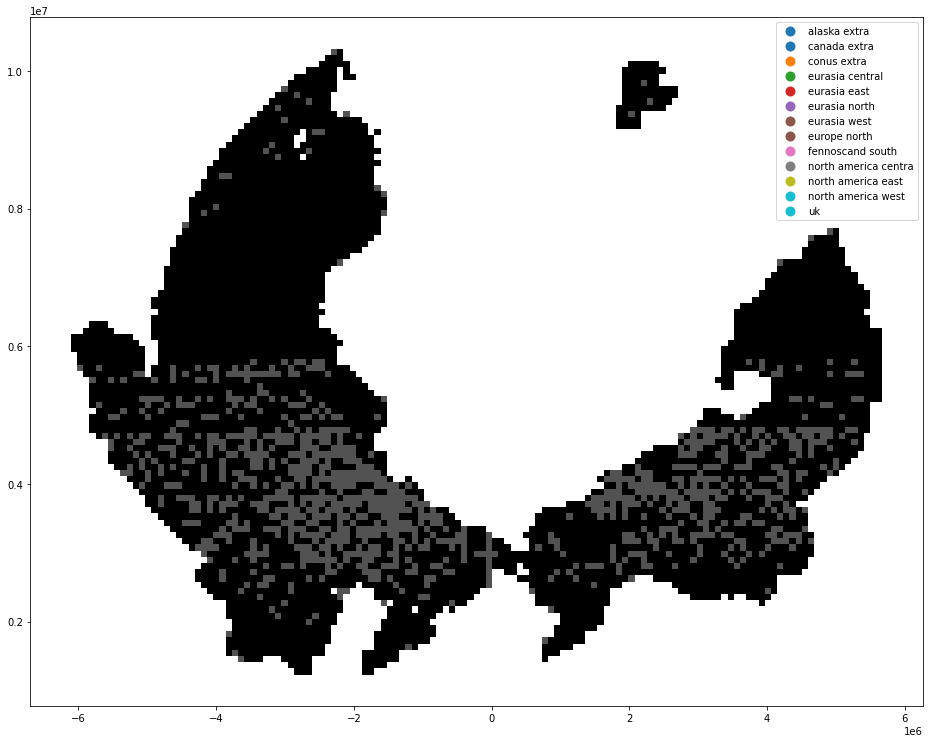

In [217]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m_list 03 04
HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')
#HLS_TILES_NEEDED = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', FIND_TILE_GROUP = 'north america west', tindex_master_fn = '/projects/shared-buckets/nathanmthomas/DPS_tile_lists/HLS_tindex_master.csv')

In [199]:
INPUT_TILE_NUM_LIST = HLS_TILES_NEEDED
len(INPUT_TILE_NUM_LIST)


1482

#### Search for tiles that need to be redone due to artifacts
    + artifacts are scene-induced - where max_cloud = 25 was a bit too harsh
    + manually specify a redo tiles list after inspecting MS comps
    + delete the existing tile dirs for those tiles

In [94]:
REDO_TILES = [
                1043, 1044, \
                34675, 34674, 34676, 35126, 35125, 35352, 1216,
                3193, 3286, 3380, 3938, 3949
             ]

REDO_TILES = [3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044, 3470]
# Get the tindex of the REDOs
redo_hls_tindex = GET_TILES_NEEDED(DPS_DATA_TYPE = 'HLS', REDO_TILES_LIST = REDO_TILES)

if False:
    # Delete the tile dirs of the tiles needing a REDO
    for file in redo_hls_tindex.local_path.to_list():
        p = os.path.split(file)[0]
        print(p)
        !rm -rf $p

/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/03/06/576992
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/10/49/813706
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/03/18/46/962548
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/13/23/44/264557
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/13/51/22/950583
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/16/44/40/040811
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/26/20/40/15/386918
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/27/18/31/48/436455
/projects/my-private-bucket/dps_output/do_HLS_stack_3-1-2_ubuntu/master/2022/03/27/18/32/28/851020


In [95]:
INPUT_TILE_NUM_LIST = REDO_TILES
print(INPUT_TILE_NUM_LIST)

[3090, 3833, 3920, 701, 747, 35577, 34443, 3949, 1044]


In [219]:
DO_EXPERIMENT = True

In [187]:
if DO_EXPERIMENT:
    
    NORWAY_TILE_LIST = pd.read_csv('/projects/shared-buckets/lduncanson/misc_files/norway_tiles.csv').layer.tolist()

    DELTA_TILE_LIST = [3365,3366,3367,3458,3459,3460,3353,3354,3355] + [3361, 3362]
    BONA_TILE_LIST  = [3270,3271,3272, 3456,3457,  3363,3364,3365] + [3268, 3269]
    HEALY_TILE_LIST = [ 3551,3552,3553,3645,3646,3647] + [3648, 3649, 3555, 3554]

    #DELTA_TILE_LIST = [3365,3366,3367,3458,3460,3353,3354,3355,3549]
    #BONA_TILE_LIST  = [3270,3271,3272,3364,3456,3457,3458,3364,3365]
    #HEALY_TILE_LIST = [3456,3457,3458,3551,3552, 3553,3645,3646,3647]
    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + DELTA_TILE_LIST + BONA_TILE_LIST + HEALY_TILE_LIST
    ALASKA_TILE_LIST =  list(range(3268,3272+1))+\
                        list(range(3361,3366+1))+\
                        list(range(3454,3459+1))+\
                        list(range(3549,3555+1))+\
                        list(range(3643,3648+1))

    INPUT_EXPERIMENT_TILE_NUM_LIST = NORWAY_TILE_LIST + ALASKA_TILE_LIST
    len(INPUT_EXPERIMENT_TILE_NUM_LIST)

In [188]:
if DO_EXPERIMENT:
    
    ILAB_AK_TILE = [3000]
    KENAI_TILE = [4017]
    ARY_MAS_TILE = [37744, 37743, 37742]
    NRWY_TILE = [131]
    SESIB_TILE = [3421]
    HOWLAND_TILE = [34210]
    BC_TILES = list(range(3846,3868+1)) 
    MISC_TILES = ARY_MAS_TILE + ILAB_AK_TILE + KENAI_TILE + HOWLAND_TILE + BC_TILES + SESIB_TILE# + NRWY_TILE
    print(len(MISC_TILES))
    
    print(len(MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST))
    
    DPS_INPUT_TILE_NUM_LIST = HOWLAND_TILE + ARY_MAS_TILE
    print(len(DPS_INPUT_TILE_NUM_LIST))
    

In [224]:
# A strip across Siberia that can be improved with shorter seaonal window and broader cloud threshold?
if DO_EXPERIMENT:
    MISC_TILES = []
    INPUT_EXPERIMENT_TILE_NUM_LIST = list(range(1620,1657 + 1))
    print(len(INPUT_EXPERIMENT_TILE_NUM_LIST))

38


In [225]:
TEST_DPS  = False

if TEST_DPS:
    print('Running DPS on a SUBSET list of input')
    DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST[-10:]
else:
    if DO_EXPERIMENT:
        print('Running DPS on the FULL list of EXPERIMENT input')
        DPS_INPUT_TILE_NUM_LIST = MISC_TILES + INPUT_EXPERIMENT_TILE_NUM_LIST
    else:
        print('Running DPS on the FULL list of input')
        DPS_INPUT_TILE_NUM_LIST = INPUT_TILE_NUM_LIST
    
print(f"List length: {len(DPS_INPUT_TILE_NUM_LIST)}")

Running DPS on the FULL list of EXPERIMENT input
List length: 38


# Run a DPS of MS Composite tiles

In [226]:
#DPS_INPUT_TILE_NUM_LIST = DPS_INPUT_TILE_NUM_LIST[2000:2100]
MAX_CLOUDS = 35
SEASON_START = '06-15'
SEASON_STOP = '09-01'
YEAR_START = '2019'
YEAR_STOP = '2021'
RUN_NAME = f'mc{MAX_CLOUDS}_{SEASON_START}_{SEASON_STOP}_{YEAR_START}_{YEAR_STOP}'
RUN_NAME

'mc35_06-15_09-01_2019_2021'

In [227]:
%%time
submit_results_df_list = []
len_input_list = len(DPS_INPUT_TILE_NUM_LIST)
print(f"# of input tiles for DPS: {len_input_list}")

for i, INPUT_TILE_NUM in enumerate(DPS_INPUT_TILE_NUM_LIST):

    DPS_num = i+1
    IDENTIFIER = "do_HLS_stack_3-1-2"
    ALGO_ID = f'{IDENTIFIER}_ubuntu'
    USER = 'nathanmthomas'
    WORKER_TYPE = 'maap-dps-worker-32gb'
    
    in_param_dict = {
                         'in_tile_fn': 'https://maap-ops-workspace.s3.amazonaws.com/shared/nathanmthomas/boreal_tiles_v003.gpkg',
                         'in_tile_num': INPUT_TILE_NUM,
                         'in_tile_layer': 'boreal_tiles_v003',
                         'sat_api': 'https://cmr.earthdata.nasa.gov/stac/LPCLOUD',
                        #'sat_api': 'https://landsatlook.usgs.gov/sat-api',
                         'tile_buffer_m': 0,
                         'start_year': YEAR_START,
                         'end_year': YEAR_STOP,
                         'start_month_day': SEASON_START,
                         'end_month_day': SEASON_STOP,
                         'max_cloud': MAX_CLOUDS,
                         'composite_type': 'HLS'
        }
        
    submit_result = maap.submitJob(
                                    identifier=IDENTIFIER,
                                    algo_id=ALGO_ID,
                                    version="master",
                                    username=USER,
                                    queue=WORKER_TYPE,
                                    # Args that match yaml
                                    **in_param_dict
        )
    
    # Build a dataframe of submission details
    submit_result['dps_num'] = DPS_num
    submit_result['tile_num'] = INPUT_TILE_NUM
    submit_result['submit_time'] = datetime.datetime.now()
    submit_result['dbs_job_hour'] =datetime.datetime.now().hour
    submit_result['algo_id'] = ALGO_ID
    submit_result['user'] = USER
    submit_result['worker_type'] = WORKER_TYPE
    
    # Append to a list of data frames of submission results
    submit_results_df_list.append(pd.DataFrame([submit_result]))
    
    if DPS_num in [1, 25,50, 100,200,300,400,500, 750, 1000, 1250, 1500, 1750, 2000, 2250, 2500, 2750, 3000, 3250, 3500, 3750, 4000, 4250, 5000, 7000, 9000, 11000, 13000, 15000, 17000, 19000, 21000, 24000, len_input_list]:
        print(f"DPS run #: {DPS_num}\t| tile num: {INPUT_TILE_NUM}\t| submit status: {submit_result['status']}\t| job id: {submit_result['job_id']}") 
        
# Build a final submission results df and save
submit_results_df = pd.concat(submit_results_df_list)
submit_results_df['run_name'] = RUN_NAME
nowtime = pd.Timestamp.now().strftime('%Y%m%d%H%M')
print(f"Current time:\t{nowtime}")
submit_results_df.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_{len_input_list}_{nowtime}.csv')
submit_results_df

# of input tiles for DPS: 38
DPS run #: 1	| tile num: 1620	| submit status: success	| job id: b53c746b-873e-476e-a5e2-803cb1e09e9a
DPS run #: 25	| tile num: 1644	| submit status: success	| job id: d4b671ea-d1c0-4b80-bd6a-eff3327422e0
DPS run #: 38	| tile num: 1657	| submit status: success	| job id: 8738dc46-855f-49fd-9963-8bfb9757acd3
Current time:	202204051457
CPU times: user 487 ms, sys: 23.2 ms, total: 510 ms
Wall time: 10.4 s


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name
0,success,200,b53c746b-873e-476e-a5e2-803cb1e09e9a,1,1620,2022-04-05 14:57:48.475856,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,619e9da6-de5e-45c0-8442-0518db7bc7af,2,1621,2022-04-05 14:57:48.597802,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,94463249-210b-4672-a315-f21bcf5e9add,3,1622,2022-04-05 14:57:48.755374,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,c4be0208-7ba2-4057-970f-80383a1b1098,4,1623,2022-04-05 14:57:48.921841,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,d9195fa5-196e-4eaa-a206-bed7e2915c32,5,1624,2022-04-05 14:57:49.190844,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,c3484f35-c73d-4f36-8192-4c33c930186e,6,1625,2022-04-05 14:57:49.431577,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,8f5ad68c-9ae8-4ef6-971c-d803cf05b155,7,1626,2022-04-05 14:57:49.785738,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,49e2cb93-9047-492e-91f1-1a8a438beb11,8,1627,2022-04-05 14:57:50.187987,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,f55c152b-9ce4-44a1-a8aa-77168a4a5913,9,1628,2022-04-05 14:57:50.425941,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021
0,success,200,4d9977a1-153f-40a2-9781-3d7175af8407,10,1629,2022-04-05 14:57:50.681127,14,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc35_06-15_09-01_2019_2021


After almost any DPS job, you have to assess what succeeded and failed. This involves:
1. building a table of job status based on job ids captured in the job_results_df from the DPS run chunk (this takes 40 mins for ~47k jobs) --> this tells you how many jobs failed
2. merging the job status table with the job results df --> this tells you which specific granules (or tile nums) failed
3. building another input list of granules for a follow-up DPS
## Assess DPS results
Build a table of job status based on job id - how many jobs failed?

In [96]:
def BUILD_TABLE_JOBSTATUS(submit_results_df):
    import xmltodict
    job_status_df = pd.concat([pd.DataFrame(xmltodict.parse(maap.getJobStatus(job_id).content)).transpose() for job_id in submit_results_df.job_id.to_list()])
    job_status_df = submit_results_df.merge(job_status_df, how='left', left_on='job_id',  right_on='wps:JobID')
    
    print(f'Count total jobs:\t{len(job_status_df)}')
    print(f"Count pending jobs:\t{job_status_df[job_status_df['wps:Status'] =='Accepted'].shape[0]}")
    print(f"Count running jobs:\t{job_status_df[job_status_df['wps:Status'] =='Running'].shape[0]}")
    
    NUM_FAILS = job_status_df[job_status_df['wps:Status'] =='Failed'].shape[0]
    NUM_SUCCEEDS = job_status_df[job_status_df['wps:Status'] =='Succeeded'].shape[0]
    print(f"Count succeeded jobs:\t{NUM_SUCCEEDS}")
    print(f"Count failed jobs:\t{NUM_FAILS}")
    if NUM_FAILS > 0:
        print(f"% of failed jobs:\t{round(NUM_FAILS / ( NUM_FAILS + NUM_SUCCEEDS ), 4) * 100}\n")
    else:
        print(f"% of failed jobs:\tNothing has failed...yet\n")
    
    return job_status_df

In [233]:
%%time
YEARDAY = '20220405'
submit_results_df_all = pd.concat([pd.read_csv(fn) for fn in glob.glob(f'/projects/my-public-bucket/DPS_do_HLS_stack_3-1-2_submission_results_*.csv') if YEARDAY in fn and not 'job_status' in fn])
z = BUILD_TABLE_JOBSTATUS(submit_results_df_all)

Count total jobs:	38
Count pending jobs:	0
Count running jobs:	0
Count succeeded jobs:	17
Count failed jobs:	21
% of failed jobs:	55.26

CPU times: user 416 ms, sys: 22.3 ms, total: 438 ms
Wall time: 1.3 s


In [99]:
# Save job status table
print(f"Current time:\t{nowtime}")
z.to_csv(f'/projects/my-public-bucket/DPS_{IDENTIFIER}_submission_results_job_status_{len(z)}_{nowtime}.csv')
z.head()

Current time:	202204011330


,status,http_status_code,job_id,dps_num,tile_num,submit_time,dbs_job_hour,algo_id,user,worker_type,run_name,@xmlns:ows,@xmlns:schemaLocation,@xmlns:wps,@xmlns:xsi,wps:JobID,wps:Status
0,success,200,52b63f88-da09-4c5b-990a-624b6efa97e8,1,40664,2022-04-01 13:30:44.146304,13,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,52b63f88-da09-4c5b-990a-624b6efa97e8,Accepted
1,success,200,4ca5fabe-a7a4-4ce1-bf3e-997a271aef27,2,40861,2022-04-01 13:30:44.251123,13,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,4ca5fabe-a7a4-4ce1-bf3e-997a271aef27,Accepted
2,success,200,78c038b6-7706-40f8-93fd-49e66ce59b41,3,40862,2022-04-01 13:30:44.356600,13,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,78c038b6-7706-40f8-93fd-49e66ce59b41,Accepted
3,success,200,7f22208b-4042-487f-bd41-c3c04f240494,4,41053,2022-04-01 13:30:44.495022,13,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,7f22208b-4042-487f-bd41-c3c04f240494,Accepted
4,success,200,55782924-b6c4-4d37-a106-50c4d6c24c22,5,41247,2022-04-01 13:30:44.700161,13,do_HLS_stack_3-1-2_ubuntu,nathanmthomas,maap-dps-worker-32gb,mc25_06-15_09-01_2019_2021,http://www.opengis.net/ows/2.0,http://schemas.opengis.net/wps/2.0/wps.xsd,http://www.opengis.net/wps/2.0,http://www.w3.org/2001/XMLSchema-instance,55782924-b6c4-4d37-a106-50c4d6c24c22,Accepted


In [155]:
print(z[z['wps:Status'] =='Succeeded'].tile_num.to_list())

[34833, 35953, 36626, 36627, 36851, 37073, 37078, 37079]


### Get a list of the FAILS to run through DPS again

In [210]:
DPS_INPUT_TILE_NUM_LIST = z[z['wps:Status'] =='Failed'].tile_num.to_list()#[0:20]
len(DPS_INPUT_TILE_NUM_LIST)

1174

In [ ]:
z[z['wps:Status'] =='Failed']

In [128]:
xmltodict.parse(maap.getJobResult(z[z['wps:Status'] =='Failed'].iloc[25].job_id).content)

OrderedDict([('wps:Result',
              OrderedDict([('@xmlns:ows', 'http://www.opengis.net/ows/2.0'),
                           ('@xmlns:schemaLocation',
                            'http://schemas.opengis.net/wps/2.0/wps.xsd'),
                           ('@xmlns:wps', 'http://www.opengis.net/wps/2.0'),
                           ('@xmlns:xsi',
                            'http://www.w3.org/2001/XMLSchema-instance'),
                           ('wps:JobID',
                            'f9241567-6d67-4338-8d66-f2e3df11db3c'),
                           ('wps:Output',
                            OrderedDict([('@id', 'traceback'),
                                         ('wps:Data',
                                          'activate does not accept more than one argument:\n[\'/app/icesat2_boreal/dps/alg_3-1-2/run.sh\', \'2590\', \'boreal_tiles_v003\', \'https://cmr.earthdata.nasa.gov/stac/LPCLOUD\', \'0\', \'2019\', \'2021\', \'06-15\', \'09-01\', \'25\', \'HLS\']\n\n+ /app/icesat2

In [ ]:
#!pip install -U -r /projects/Developer/icesat2_boreal/dps/requirements_main.txt

In [154]:
!python /projects/Developer/icesat2_boreal/lib/build_tindex_master.py -t HLS -y 2022 -m 03 -d_min 23

/projects/.local/lib/python3.7/site-packages/geopandas/_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string

Building a list of tiles:
MAAP version:		master
Type:		HLS
Year:		2022
Month:		03
Days:		23-31

Output dir:  /projects/my-public-bucket/DPS_tile_lists
                                             s3_path  ...                                file
0  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_7_06-01_09-15_2019_2021.tif
1  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_178_06-01_09-15_2019_2021.tif
2  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...   HLS_275_06-01_09-15_2019_2021.tif
3  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...  HLS_3848_06-01_09-15_2019_2021.tif
4  s3://maap-ops-workspace/nathanmthomas/dps_outp...  ...     HLS_4_06-01_0